In [1]:
#hide
# !pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

In [2]:
#hide
from fastbook import *
from fastai.vision.widgets import *

# Step 1: Gather data

In [3]:
key = os.environ.get('AZURE_SEARCH_KEY', '8c6f869e84864c07bc35b3c677adfe09')

In [4]:
search_images_bing

<function fastbook.search_images_bing(key, term, min_sz=128, max_images=150)>

In [5]:
food_types = 'apple','orange','banana','blueberry','pear'
path = Path('foods')

In [6]:
if not path.exists():
    path.mkdir()
    for o in food_types:
        dest = (path/o)
        dest.mkdir(exist_ok=True)
        results = search_images_bing(key, f'{o}')
        # results = search_images_bing(key, f'{o} bear')
        download_images(dest, urls=results.attrgot('contentUrl'))

In [7]:
fns = get_image_files(path)
fns

(#688) [Path('foods/apple/00000002.jpg'),Path('foods/apple/00000004.JPG'),Path('foods/apple/00000003.jpg'),Path('foods/apple/00000009.jpg'),Path('foods/apple/00000007.jpg'),Path('foods/apple/00000010.jpg'),Path('foods/apple/00000012.jpg'),Path('foods/apple/00000013.jpg'),Path('foods/apple/00000016.jpg'),Path('foods/apple/00000008.jpg')...]

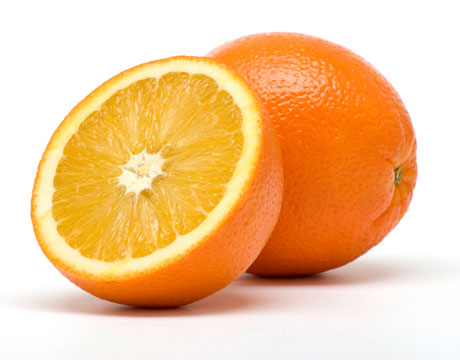

In [11]:
# Image.open(fns[160])

In [12]:
failed = verify_images(fns)
failed.map(Path.unlink)

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:792: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))


(#5) [Path('foods/orange/00000083.jpg'),Path('foods/orange/00000148.jpg'),Path('foods/banana/00000079.jpg'),Path('foods/banana/00000108.jpg'),Path('foods/pear/00000039.jpg')]

In [15]:
# ?verify_images

Here are some other features that are very useful in Jupyter notebooks:

- At any point, if you don't remember the exact spelling of a function or argument name, you can press Tab to get autocompletion suggestions.
- When inside the parentheses of a function, pressing Shift and Tab simultaneously will display a window with the signature of the function and a short description. Pressing these keys twice will expand the documentation, and pressing them three times will open a full window with the same information at the bottom of your screen.
- In a cell, typing `?func_name` and executing will open a window with the signature of the function and a short description.
- In a cell, typing `??func_name` and executing will open a window with the signature of the function, a short description, and the source code.
- If you are using the fastai library, we added a `doc` function for you: executing `doc(func_name)` in a cell will open a window with the signature of the function, a short description and links to the source code on GitHub and the full documentation of the function in the [library docs](https://docs.fast.ai).
- Unrelated to the documentation but still very useful: to get help at any point if you get an error, type `%debug` in the next cell and execute to open the [Python debugger](https://docs.python.org/3/library/pdb.html), which will let you inspect the content of every variable.

# Step 2: Clean data before training [DataLoaders]

Now that we have downloaded some data, we need to assemble it in a format suitable for model training. In fastai, that means creating an object called `DataLoaders`.

`DataLoaders` is a thin class that just stores whatever `DataLoader` objects you pass to it, and makes them available as `train` and `valid`. Although it's a very simple class, it's very important in fastai: it provides the data for your model. The key functionality in `DataLoaders` is provided with just these four lines of code (it has some other minor functionality we'll skip over for now):

```python
class DataLoaders(GetAttr):
    def __init__(self, *loaders): self.loaders = loaders
    def __getitem__(self, i): return self.loaders[i]
    train,valid = add_props(lambda i,self: self[i])
```

> jargon: DataLoaders: A fastai class that stores multiple `DataLoader` objects you pass to it, normally a `train` and a `valid`, although it's possible to have as many as you like. The first two are made available as properties.

To turn our downloaded data into a `DataLoaders` object we need to tell fastai at least four things:

- What kinds of data we are working with
- How to get the list of items
- How to label these items
- How to create the validation set

In [30]:
foods = DataBlock(
    blocks = (ImageBlock, CategoryBlock), # independent, dependent variables
    get_items = get_image_files, # we are using file paths in this project, so g_i_f returns all images in that path
    splitter = RandomSplitter(valid_pct=0.2, seed=42), # we want to split train and val sets randomly. we use RandomSplitter but can create our own if necessary.
    get_y = parent_label, # telling fastai what function to call to create labels (Y data)
    # parent_label ^^ provided by fastai that gets the folder that it is in. so it gets label from "../food/apple/001.jpg"
    # item_tfms=Resize(128) # we need images in same size, so fastai provides Resize()
    item_tfms=RandomResizedCrop(224, min_scale=0.3) # instead of above, we use this to resize the images in different ways each epoch
    # min_scale ^^ determines how much of image to select at minimum each time
)


We have now created a `DataBlock` object: First step in creating a `DataLoaders` object

A `DataLoaders` includes validation and training `DataLoader`s. `DataLoader` is a class that provides batches of a few items at a time to the GPU. We'll be learning a lot more about this class in the next chapter. When you loop through a `DataLoader` fastai will give you 64 (by default) items at a time, all stacked up into a single tensor. We can take a look at a few of those items by calling the `show_batch` method on a `DataLoader`:

In [57]:
#foods = foods.new(item_tfms=RandomResizedCrop(224, min_scale=0.3), batch_tfms=aug_transforms(mult=2)) # I NEED to define item_tfms when initializing
#foods = foods.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
foods = foods.new(item_tfms=RandomResizedCrop(224, min_scale=0.5), batch_tfms=aug_transforms()) # I NEED to define item_tfms when initializing
# default aug_transforms^^
dls = foods.dataloaders(path) # tells fastai the source of the data

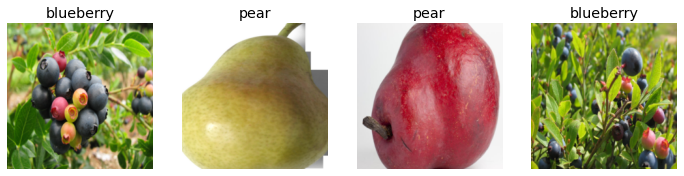

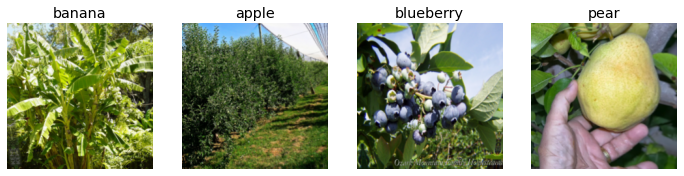

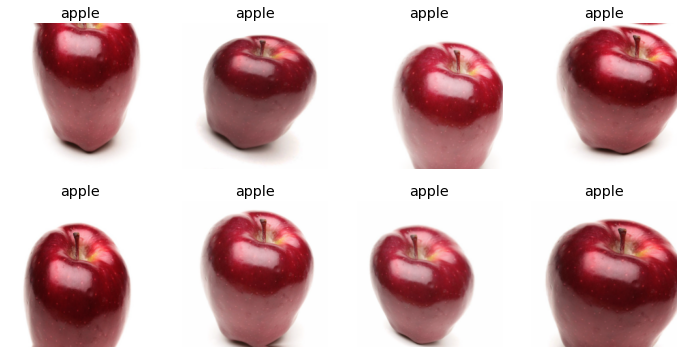

In [44]:
# Display batches

#foods = foods.new(item_tfms=RandomResizedCrop(128, min_scale=0.3))
dls.valid.show_batch(max_n=4, nrows=1) # show_batch on a DataLoader to take a look at some val data
dls.train.show_batch(max_n=4, nrows=1) # show_batch on a DataLoader to take a look at some train data
dls.train.show_batch(max_n=8, nrows=2, unique=True) # show_batch on a DataLoader to take a look at some train data

# Step 3: Train the Model (and use it to clean the data)

Create a `Learner` and fine-tune it

In [60]:
learn = cnn_learner(dls, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.183403,0.714162,0.237037,00:13


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:792: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


epoch,train_loss,valid_loss,error_rate,time
0,0.965389,0.546595,0.177778,00:12
1,0.744705,0.493179,0.140741,00:13
2,0.588709,0.505925,0.133333,00:11
3,0.474005,0.481813,0.125926,00:12


/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:792: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:7

In [61]:
??ClassificationInterpretation

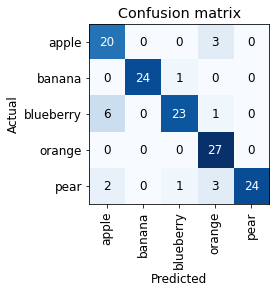

In [63]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

It's helpful to see where exactly our errors are occurring, to see whether they're due to a dataset problem (e.g., images that aren't bears at all, or are labeled incorrectly, etc.), or a model problem (perhaps it isn't handling images taken with unusual lighting, or from a different angle, etc.). To do this, we can sort our images by their *loss*.

`plot_top_losses` shows us the images with the highest loss in our dataset. As the title of the output says, each image is labeled with four things: prediction, actual (target label), loss, and probability. The *probability* here is the confidence level, from zero to one, that the model has assigned to its prediction:

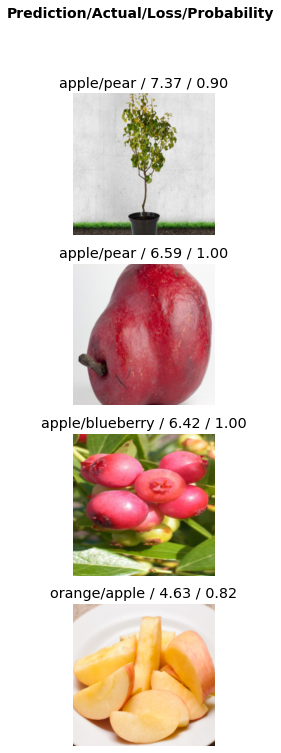

In [64]:
interp.plot_top_losses(4, nrows=4)

#### To clean up the data:
use the following GUI to delete data or recategorize a label

In [65]:
#hide_output
cleaner = ImageClassifierCleaner(learn)
cleaner

/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/TiffImagePlugin.py:792: UserWarning: Corrupt EXIF data.  Expecting to read 4 bytes but only got 0. 
  warnings.warn(str(msg))
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(
/opt/conda/envs/fastai/lib/python3.8/site-packages/PIL/Image.py:951: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


`ImageClassifierCleaner` doesn't actually do the deleting or changing of labels for you; it just returns the indices of items to change


After cleaning up the data - retrain the model!

In [54]:
#hide
for idx in cleaner.delete(): cleaner.fns[idx].unlink() # to delete the images from ICC
# for idx,cat in cleaner.change(): shutil.move(str(cleaner.fns[idx]), path/cat) # to move images to another label from ICC

> s: Cleaning the data and getting it ready for your model are two of the biggest challenges for data scientists; they say it takes 90% of their time. The fastai library aims to provide tools that make it as easy as possible.


# Step 4: Turn Model into Online App!

In [66]:
learn.export() # saves the trained parameters AND architecture

In [67]:
path = Path()
path.ls(file_exts='.pkl')

(#1) [Path('export.pkl')]

^^ I need this file to deploy my app wherever

#### Next: need a Inference Learner
  When we use a model for getting predictions, instead of training, its called inference

In [68]:
learn_inf = load_learner(path/'export.pkl')

In [86]:
img='https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcRqjhU8bfGVKMExtznFecpFB-c41jizxviMmw&usqp=CAU'
dest='images/googletestpear.jpg'
download_url(img, dest)

In [87]:
learn_inf.predict(dest)

('pear',
 tensor(4),
 tensor([1.1569e-04, 3.8683e-04, 7.3639e-03, 1.6992e-03, 9.9043e-01]))

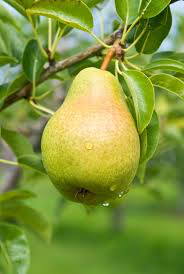

In [88]:
Image.open(dest)

In [93]:
learn_inf.dls.vocab

['apple', 'banana', 'blueberry', 'orange', 'pear']

#### Creating the app in Jupyter

To use our model - treat `predict` method like a regular function

In [94]:
#hide_output
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [98]:
#hide
# For the book, we can't actually click an upload button, so we fake it
btn_upload = SimpleNamespace(data = ['images/googletestpear.jpg'])

In [100]:
img = PILImage.create(btn_upload.data[-1])

In [101]:
#hide_output
out_pl = widgets.Output()
out_pl.clear_output()
with out_pl: display(img.to_thumb(128,128))
out_pl

Output()

In [102]:
pred,pred_idx,probs = learn_inf.predict(img)

### Here is where we get our predictions

In [103]:
#hide_output
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: pear; Probability: 0.9904')

In [104]:
#hide_output
btn_run = widgets.Button(description='Classify')
btn_run

Button(description='Classify', style=ButtonStyle())

IndexError: list index out of range

IndexError: list index out of range

We'll also need a *click event handler*; that is, a function that will be called when it's pressed. We can just copy over the lines of code from above:

In [106]:
def on_click_classify(change):
    img = PILImage.create(btn_upload.data[-1])
    out_pl.clear_output()
    with out_pl: display(img.to_thumb(128,128))
    pred,pred_idx,probs = learn_inf.predict(img)
    lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'

btn_run.on_click(on_click_classify)

In [107]:
#hide
#Putting back btn_upload to a widget for next cell
btn_upload = widgets.FileUpload()

In [108]:
#hide_output
VBox([widgets.Label('Select your food!'), 
      btn_upload, btn_run, out_pl, lbl_pred])

#### Next: turn Notebook into a Real App

In [110]:
#hide
!pip install voila
!jupyter serverextension enable --sys-prefix voila 

     |████████████████████████████████| 1.9 MB 31.8 MB/s eta 0:00:01
     |████████████████████████████████| 552 kB 51.7 MB/s eta 0:00:01
     |████████████████████████████████| 223 kB 37.6 MB/s eta 0:00:01
  Attempting uninstall: nbconvert
    Found existing installation: nbconvert 5.6.1
    Uninstalling nbconvert-5.6.1:
      Successfully uninstalled nbconvert-5.6.1
ERROR: After October 2020 you may experience errors when installing or updating packages. This is because pip will change the way that it resolves dependency conflicts.

We recommend you use --use-feature=2020-resolver to test your packages with the new resolver before it becomes the default.

nbdev 1.1.5 requires nbconvert<6, but you'll have nbconvert 6.0.7 which is incompatible.
Enabling: voila
- Writing config: /opt/conda/envs/fastai/etc/jupyter
    - Validating...
      voila 0.2.4 OK


As you now know, you need a GPU to train nearly any useful deep learning model. So, do you need a GPU to use that model in production? No! You almost certainly *do not need a GPU to serve your model in production*. There are a few reasons for this:

- As we've seen, GPUs are only useful when they do lots of identical work in parallel. If you're doing (say) image classification, then you'll normally be classifying just one user's image at a time, and there isn't normally enough work to do in a single image to keep a GPU busy for long enough for it to be very efficient. So, a CPU will often be more cost-effective.
- There's a lot more market competition in CPU than GPU servers, as a result of which there are much cheaper options available for CPU servers.

Because of the complexity of GPU serving, many systems have sprung up to try to automate this. However, managing and running these systems is also complex, and generally requires compiling your model into a different form that's specialized for that system. It's typically preferable to avoid dealing with this complexity until/unless your app gets popular enough that it makes clear financial sense for you to do so.